In [18]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('Clean_Dataset.csv') 
print("Dataset loaded successfully from CSV")

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\n Dataset Info:")
print(df.info())

print("\n Price Statistics:")
print(df['price'].describe())

Dataset loaded successfully from CSV
Dataset shape: (300153, 12)

First 5 rows:


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955



 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB
None

 Price Statistics:
count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.00000

In [20]:
print(df.columns)

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')


In [21]:
#data cleaning
df_clean = df.copy()

print("Missing values per column:")
print(df_clean.isnull().sum())

for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype == 'object':
            df_clean[col].fillna('Unknown', inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(" Missing values handled")

def duration_to_minutes(duration):
    """Convert duration string to total minutes"""
    try:
        if isinstance(duration, str):
            if 'h' in duration and 'm' in duration:
                hours = int(duration.split('h')[0])
                minutes = int(duration.split('h')[1].split('m')[0])
                return hours * 60 + minutes
            elif 'h' in duration:
                return int(duration.replace('h', '')) * 60
            else:
                return int(duration.replace('m', ''))
        return 120
    except:
        return 120

df_clean['duration_minutes'] = df_clean['duration'].apply(duration_to_minutes)

def time_to_hour(time_str):
    """Convert categorical time to hour of day"""
    time_mapping = {
        'Morning': 8,    # 8 AM
        'Afternoon': 14, # 2 PM  
        'Evening': 19,   # 7 PM
        'Night': 22,     # 10 PM
        'Late Night': 1, # 1 AM
        'Early Morning': 5 # 5 AM
    }
    return time_mapping.get(time_str, 12)

df_clean['dep_hour'] = df_clean['departure_time'].apply(time_to_hour)
df_clean['arrival_hour'] = df_clean['arrival_time'].apply(time_to_hour)
df_clean['is_peak_hour'] = ((df_clean['dep_hour'] >= 7) & (df_clean['dep_hour'] <= 9)) | \
                          ((df_clean['dep_hour'] >= 17) & (df_clean['dep_hour'] <= 19))

print(" Time features extracted")

Missing values per column:
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
 Missing values handled
 Time features extracted


In [22]:
# Feature engineering
df_clean['route'] = df_clean['source_city'] + '-' + df_clean['destination_city']

np.random.seed(42)
df_clean['demand_factor'] = np.random.uniform(0.3, 2.5, len(df_clean))

df_clean['competitor_price'] = df_clean['price'] * np.random.uniform(0.8, 1.3, len(df_clean))

def is_likely_weekend(departure_time):
    """Estimate if flight is likely on weekend based on departure time"""
    weekend_times = ['Evening', 'Night', 'Late Night']
    return 1 if departure_time in weekend_times else 0

df_clean['is_weekend'] = df_clean['departure_time'].apply(is_likely_weekend)
df_clean['booking_urgency'] = 1 / (df_clean['days_left'] + 1)

route_popularity = df_clean['route'].value_counts().to_dict()
df_clean['route_popularity'] = df_clean['route'].map(route_popularity)

df_clean['price_ratio_vs_competitor'] = df_clean['price'] / df_clean['competitor_price']
df_clean['price_advantage'] = (df_clean['competitor_price'] - df_clean['price']) / df_clean['competitor_price']

print(" Engineered features created:")
new_features = ['duration_minutes', 'demand_factor', 'competitor_price', 'is_peak_hour', 
                'is_weekend', 'booking_urgency', 'route_popularity', 'price_ratio_vs_competitor', 'price_advantage']
print(new_features)

 Engineered features created:
['duration_minutes', 'demand_factor', 'competitor_price', 'is_peak_hour', 'is_weekend', 'booking_urgency', 'route_popularity', 'price_ratio_vs_competitor', 'price_advantage']


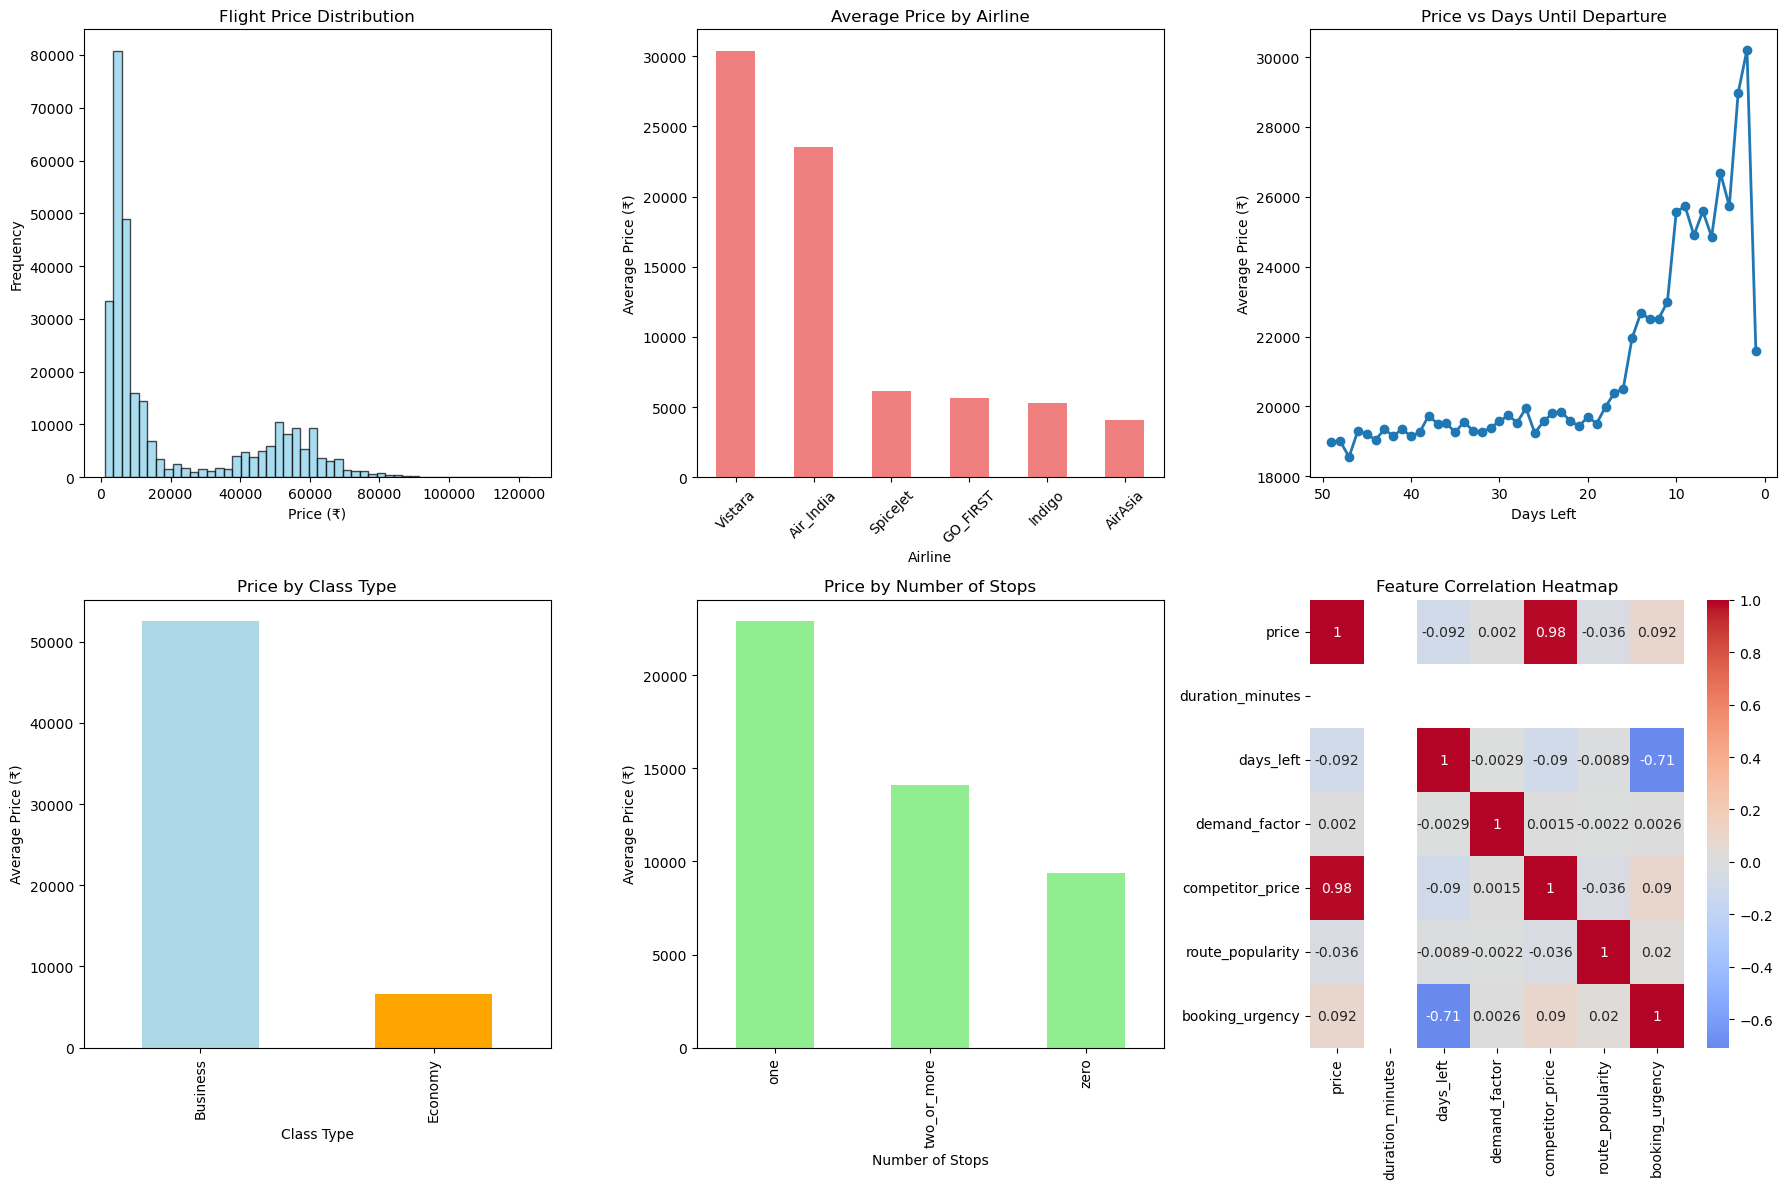

In [23]:
# EDA
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Price distribution
axes[0,0].hist(df_clean['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Flight Price Distribution')
axes[0,0].set_xlabel('Price (₹)')
axes[0,0].set_ylabel('Frequency')

# Price by airline
airline_prices = df_clean.groupby('airline')['price'].mean().sort_values(ascending=False)
airline_prices.plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Average Price by Airline')
axes[0,1].set_xlabel('Airline')
axes[0,1].set_ylabel('Average Price (₹)')
axes[0,1].tick_params(axis='x', rotation=45)

# Price vs Days Left
days_left_avg = df_clean.groupby('days_left')['price'].mean()
axes[0,2].plot(days_left_avg.index, days_left_avg.values, marker='o', linewidth=2)
axes[0,2].set_title('Price vs Days Until Departure')
axes[0,2].set_xlabel('Days Left')
axes[0,2].set_ylabel('Average Price (₹)')
axes[0,2].invert_xaxis()

# Price by class
class_prices = df_clean.groupby('class')['price'].mean()
class_prices.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'orange'])
axes[1,0].set_title('Price by Class Type')
axes[1,0].set_xlabel('Class Type')
axes[1,0].set_ylabel('Average Price (₹)')

# Price by stops
stops_prices = df_clean.groupby('stops')['price'].mean().sort_index()
stops_prices.plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Price by Number of Stops')
axes[1,1].set_xlabel('Number of Stops')
axes[1,1].set_ylabel('Average Price (₹)')

# Correlation heatmap
numeric_columns = ['price', 'duration_minutes', 'days_left', 'demand_factor', 
                  'competitor_price', 'route_popularity', 'booking_urgency']
sns.heatmap(df_clean[numeric_columns].corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

In [24]:
# featured for modeling

feature_columns = [
    'airline', 'source_city', 'destination_city', 'route', 'stops', 'class',
    'duration_minutes', 'dep_hour', 'arrival_hour', 'is_peak_hour', 
    'days_left', 'demand_factor', 'competitor_price', 'is_weekend',
    'booking_urgency', 'route_popularity', 'price_ratio_vs_competitor', 'price_advantage'
]

label_encoders = {}
categorical_columns = ['airline', 'source_city', 'destination_city', 'route', 'stops', 'class']

for col in categorical_columns:
    le = LabelEncoder()
    df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])
    label_encoders[col] = le
    feature_columns = [col + '_encoded' if x == col else x for x in feature_columns]

X = df_clean[feature_columns]
y = df_clean['price']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Data preparation completed")


Feature matrix shape: (300153, 18)
Target variable shape: (300153,)
Training set: (240122, 18)
Test set: (60031, 18)
 Data preparation completed


In [25]:
#RandomForestRegressor(n_jobs=1)

# model selection and training
models = {
    # Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    
    # Tree based Models
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    
    # Other Models
    #'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    #'Support Vector': SVR(kernel='rbf', C=1.0)
}

results = {}
training_times = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    
    try:
        start_time = pd.Timestamp.now()
        # if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet', 'K-Neighbors', 'Support Vector']:
        if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            used_scaled_data = True
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            used_scaled_data = False
        
        end_time = pd.Timestamp.now()
        training_time = (end_time - start_time).total_seconds()

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        with np.errstate(divide='ignore', invalid='ignore'):
            absolute_percentage_errors = np.abs((y_test - y_pred) / y_test)
            absolute_percentage_errors = np.nan_to_num(absolute_percentage_errors, nan=1.0, posinf=1.0, neginf=1.0)
            mape = np.mean(absolute_percentage_errors) * 100

        max_error = np.max(np.abs(y_test - y_pred))
        explained_variance = 1 - (np.var(y_test - y_pred) / np.var(y_test)) if np.var(y_test) > 0 else 0
        
        results[name] = {
            'model': model,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'mse': mse,
            'max_error': max_error,
            'explained_variance': explained_variance,
            'predictions': y_pred,
            'used_scaled_data': used_scaled_data
        }
        
        training_times[name] = training_time
        
        print(f" {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
        print(f"   Training time: {training_time:.2f}s")
        
    except Exception as e:
        print(f" Error training {name}: {e}")
        continue


 Training Linear Regression...
 Linear Regression - RMSE: 2859.66, MAE: 2134.05, R²: 0.9841, MAPE: 24.20%
   Training time: 0.17s

 Training Ridge Regression...
 Ridge Regression - RMSE: 2859.66, MAE: 2134.03, R²: 0.9841, MAPE: 24.20%
   Training time: 0.05s

 Training Lasso Regression...
 Lasso Regression - RMSE: 2859.64, MAE: 2133.99, R²: 0.9841, MAPE: 24.19%
   Training time: 2.23s

 Training ElasticNet...
 ElasticNet - RMSE: 3188.20, MAE: 2208.69, R²: 0.9803, MAPE: 22.75%
   Training time: 0.58s

 Training Decision Tree...
 Decision Tree - RMSE: 192.19, MAE: 45.26, R²: 0.9999, MAPE: 0.22%
   Training time: 6.70s

 Training Random Forest...
 Random Forest - RMSE: 84.99, MAE: 21.15, R²: 1.0000, MAPE: 0.10%
   Training time: 448.32s

 Training Gradient Boosting...
 Gradient Boosting - RMSE: 395.95, MAE: 249.27, R²: 0.9997, MAPE: 2.04%
   Training time: 142.98s

 Training Extra Trees...
 Extra Trees - RMSE: 90.46, MAE: 18.21, R²: 1.0000, MAPE: 0.09%
   Training time: 218.20s

 Trainin

In [26]:
if results:
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[name]['rmse'] for name in results],
        'MAE': [results[name]['mae'] for name in results],
        'R²': [results[name]['r2'] for name in results],
        'MAPE': [results[name]['mape'] for name in results],
        'Training_Time(s)': [training_times[name] for name in results],
        'Max_Error': [results[name]['max_error'] for name in results]
    }).sort_values('MAPE')

    print("\n MODEL PERFORMANCE RANKING (Sorted by MAPE):")
    display(comparison_df.round(4))

    best_by_mape = comparison_df.iloc[0]['Model']
    best_by_r2 = comparison_df.loc[comparison_df['R²'].idxmax()]['Model']
    best_by_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin()]['Model']
    fastest_model = comparison_df.loc[comparison_df['Training_Time(s)'].idxmin()]['Model']
    
    print(f"\n BEST MODELS BY DIFFERENT METRICS:")
    print(f"• Best MAPE (Accuracy): {best_by_mape} - {comparison_df.iloc[0]['MAPE']:.2f}%")
    print(f"• Best R² (Variance Explained): {best_by_r2} - {comparison_df.loc[comparison_df['R²'].idxmax()]['R²']:.4f}")
    print(f"• Best RMSE: {best_by_rmse} - {comparison_df.loc[comparison_df['RMSE'].idxmin()]['RMSE']:.2f}")
    print(f"• Fastest Training: {fastest_model} - {comparison_df.loc[comparison_df['Training_Time(s)'].idxmin()]['Training_Time(s)']:.2f}s")

    best_model_name = best_by_mape
    best_model = results[best_model_name]['model']
    best_metrics = results[best_model_name]
    best_model_used_scaled = results[best_model_name]['used_scaled_data']
    
    print(f"\n SELECTED BEST OVERALL MODEL: {best_model_name}")
    print(f"RMSE: {best_metrics['rmse']:.2f}")
    print(f"MAE: {best_metrics['mae']:.2f}")
    print(f"R²: {best_metrics['r2']:.4f}")
    print(f"MAPE: {best_metrics['mape']:.2f}%")
    
else:
    print(" No models were successfully trained!")
    print("Training fallback model (Random Forest)...")
    fallback_model = RandomForestRegressor(n_estimators=100, random_state=42)
    fallback_model.fit(X_train, y_train)
    y_pred_fallback = fallback_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_fallback)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_fallback)
    r2 = r2_score(y_test, y_pred_fallback)
    mape = np.mean(np.abs((y_test - y_pred_fallback) / y_test)) * 100
    
    results['Random Forest (Fallback)'] = {
        'model': fallback_model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'used_scaled_data': False
    }
    
    best_model_name = 'Random Forest (Fallback)'
    best_model = fallback_model
    best_metrics = results[best_model_name]
    best_model_used_scaled = False



 MODEL PERFORMANCE RANKING (Sorted by MAPE):


,Model,RMSE,MAE,R²,MAPE,Training_Time(s),Max_Error
7,Extra Trees,90.4572,18.2097,1.0000,0.0867,218.2043,6976.0700
5,Random Forest,84.9909,21.1535,1.0000,0.0963,448.3168,7758.3000
4,Decision Tree,192.1916,45.2574,0.9999,0.2182,6.6962,12563.0000
8,XGBoost,468.0125,147.0950,0.9996,0.8719,1.7171,27001.7344
6,Gradient Boosting,395.9464,249.2694,0.9997,2.0398,142.9814,8162.1231
3,ElasticNet,3188.2043,2208.6891,0.9803,22.7548,0.5847,30043.8957
2,Lasso Regression,2859.6358,2133.9928,0.9841,24.1950,2.2279,22867.0241
1,Ridge Regression,2859.6564,2134.0341,0.9841,24.1962,0.0490,22875.6045
0,Linear Regression,2859.6550,2134.0467,0.9841,24.1966,0.1676,22874.9410



 BEST MODELS BY DIFFERENT METRICS:
• Best MAPE (Accuracy): Extra Trees - 0.09%
• Best R² (Variance Explained): Random Forest - 1.0000
• Best RMSE: Random Forest - 84.99
• Fastest Training: Ridge Regression - 0.05s

 SELECTED BEST OVERALL MODEL: Extra Trees
RMSE: 90.46
MAE: 18.21
R²: 1.0000
MAPE: 0.09%


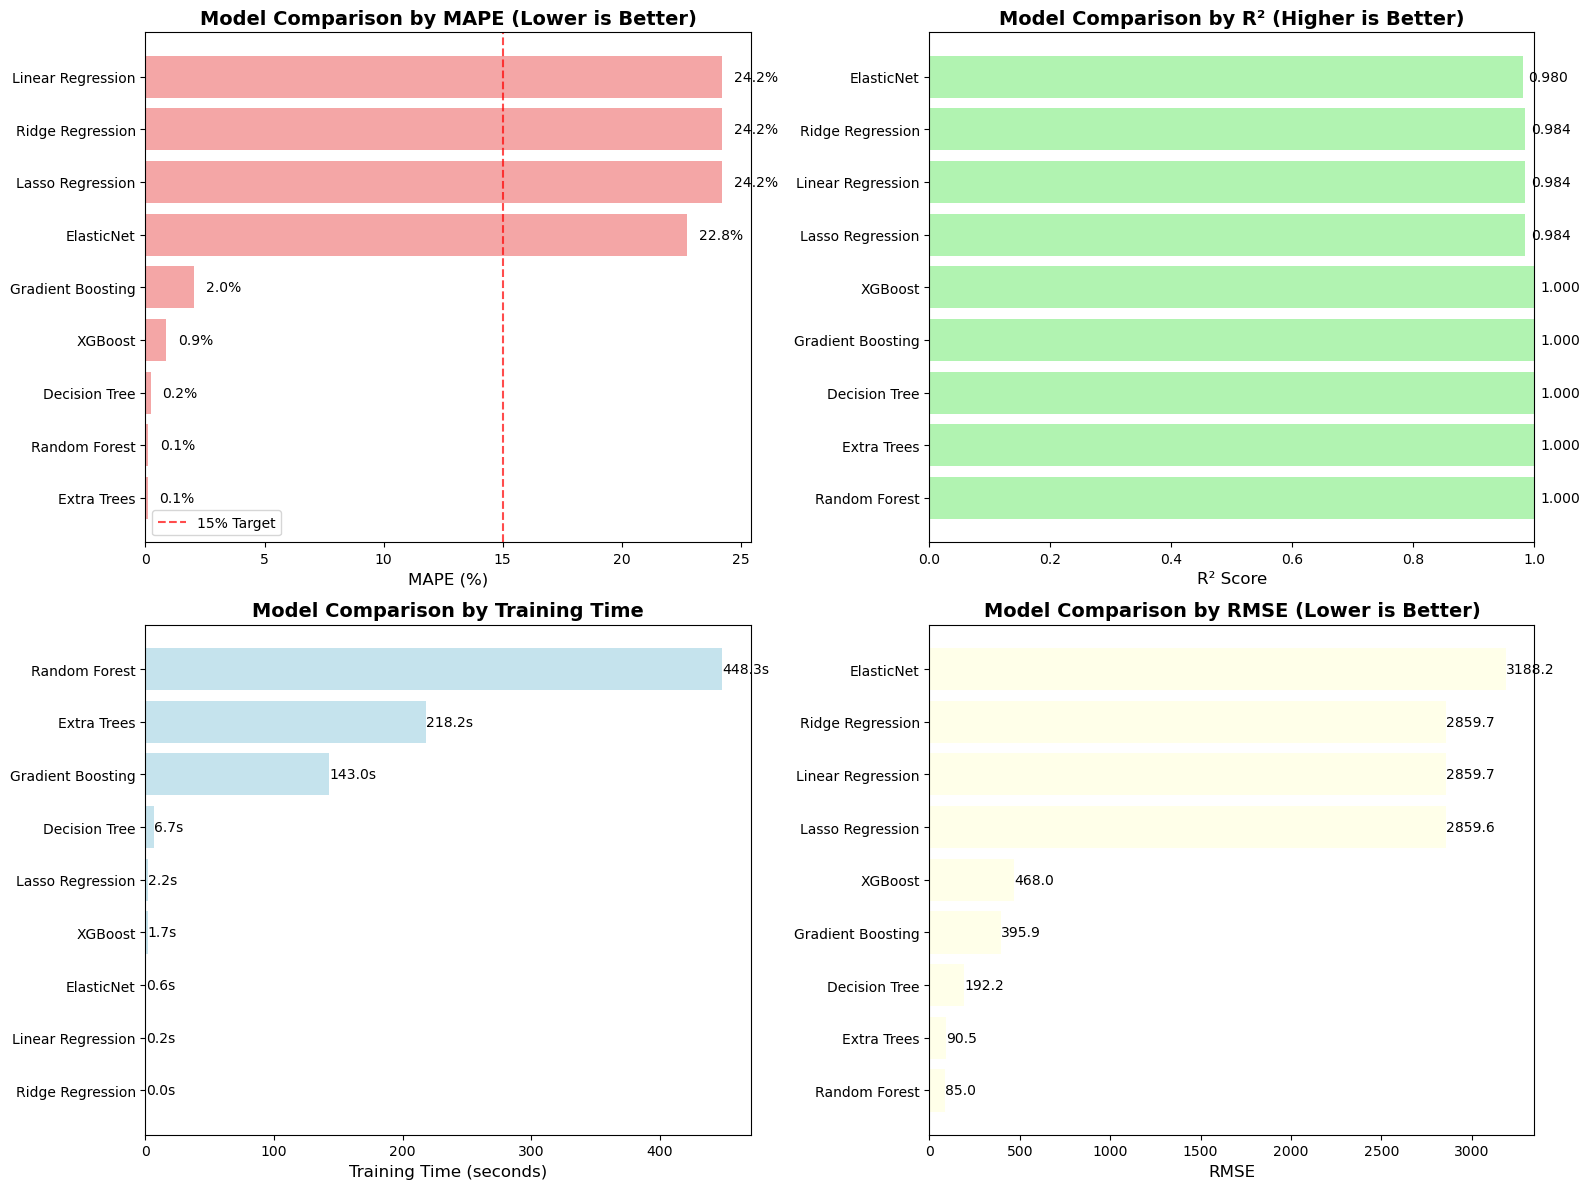


 BEST MODELS BY ALGORITHM CATEGORY:
• Best Linear Model: ElasticNet (MAPE: 22.75%)
• Best Tree-based Model: Extra Trees (MAPE: 0.09%)


In [27]:
try:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # MAPE Comparison 
    mape_data = [(name, results[name]['mape']) for name in results]
    mape_data.sort(key=lambda x: x[1])
    models_mape, mape_values = zip(*mape_data)
    
    bars1 = axes[0, 0].barh(models_mape, mape_values, color='lightcoral', alpha=0.7)
    axes[0, 0].set_xlabel('MAPE (%)', fontsize=12)
    axes[0, 0].set_title('Model Comparison by MAPE (Lower is Better)', fontsize=14, fontweight='bold')
    axes[0, 0].axvline(x=15, color='red', linestyle='--', alpha=0.7, label='15% Target')
    axes[0, 0].legend()

    for bar, value in zip(bars1, mape_values):
        axes[0, 0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                       f'{value:.1f}%', ha='left', va='center', fontsize=10)
    
    # R² Comparison
    r2_data = [(name, results[name]['r2']) for name in results]
    r2_data.sort(key=lambda x: x[1], reverse=True)
    models_r2, r2_values = zip(*r2_data)
    
    bars2 = axes[0, 1].barh(models_r2, r2_values, color='lightgreen', alpha=0.7)
    axes[0, 1].set_xlabel('R² Score', fontsize=12)
    axes[0, 1].set_title('Model Comparison by R² (Higher is Better)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim(0, 1)

    for bar, value in zip(bars2, r2_values):
        axes[0, 1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{value:.3f}', ha='left', va='center', fontsize=10)
    
    # Training Time Comparison
    time_data = [(name, training_times[name]) for name in results]
    time_data.sort(key=lambda x: x[1])
    models_time, time_values = zip(*time_data)
    
    bars3 = axes[1, 0].barh(models_time, time_values, color='lightblue', alpha=0.7)
    axes[1, 0].set_xlabel('Training Time (seconds)', fontsize=12)
    axes[1, 0].set_title('Model Comparison by Training Time', fontsize=14, fontweight='bold')

    for bar, value in zip(bars3, time_values):
        axes[1, 0].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                       f'{value:.1f}s', ha='left', va='center', fontsize=10)
    
    # RMSE Comparison
    rmse_data = [(name, results[name]['rmse']) for name in results]
    rmse_data.sort(key=lambda x: x[1])
    models_rmse, rmse_values = zip(*rmse_data)
    
    bars4 = axes[1, 1].barh(models_rmse, rmse_values, color='lightyellow', alpha=0.7)
    axes[1, 1].set_xlabel('RMSE', fontsize=12)
    axes[1, 1].set_title('Model Comparison by RMSE (Lower is Better)', fontsize=14, fontweight='bold')

    for bar, value in zip(bars4, rmse_values):
        axes[1, 1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                       f'{value:.1f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    linear_models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']
    tree_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Extra Trees', 'XGBoost']
    other_models = ['K-Neighbors', 'Support Vector']
    
    def get_best_in_category(category_names, results_dict):
        category_results = {name: results_dict[name] for name in category_names if name in results_dict}
        if category_results:
            best_in_cat = min(category_results.keys(), key=lambda x: category_results[x]['mape'])
            return best_in_cat, category_results[best_in_cat]['mape']
        return None, None
    
    best_linear, linear_mape = get_best_in_category(linear_models, results)
    best_tree, tree_mape = get_best_in_category(tree_models, results)
    best_other, other_mape = get_best_in_category(other_models, results)
    
    print(f"\n BEST MODELS BY ALGORITHM CATEGORY:")
    if best_linear:
        print(f"• Best Linear Model: {best_linear} (MAPE: {linear_mape:.2f}%)")
    if best_tree:
        print(f"• Best Tree-based Model: {best_tree} (MAPE: {tree_mape:.2f}%)")
    if best_other:
        print(f"• Best Other Model: {best_other} (MAPE: {other_mape:.2f}%)")

except Exception as e:
    print(f" Error in model comparison visualization: {e}")

In [28]:
# hyperparameter tuning
if best_model_name and best_model_name != 'Linear Regression':
    print(f"\n Hyperparameter Tuning for {best_model_name}...")
    
    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        
        grid_search = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        if best_model_used_scaled:
            grid_search.fit(X_train_scaled, y_train)
        else:
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 4]
        }
        
        grid_search = GridSearchCV(
            GradientBoostingRegressor(random_state=42),
            param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        if best_model_used_scaled:
            grid_search.fit(X_train_scaled, y_train)
        else:
            grid_search.fit(X_train, y_train)
            
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
    
else:
    print("No hyperparameter tuning needed for Linear Regression")
    best_model = results[best_model_name]['model']


 Hyperparameter Tuning for Extra Trees...


In [29]:
# model evaluation
try:
    if best_model_name == 'Linear Regression':
        y_pred_final = best_model.predict(X_test_scaled)
    else:
        y_pred_final = best_model.predict(X_test)

    if np.any(np.isnan(y_pred_final)) or np.any(np.isinf(y_pred_final)):
        print(" WARNING: Model produced invalid predictions")
        y_pred_final = np.nan_to_num(y_pred_final, nan=y_test.mean())
        y_pred_final = np.clip(y_pred_final, 0, None)

    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
    final_mae = mean_absolute_error(y_test, y_pred_final)
    final_r2 = r2_score(y_test, y_pred_final)

    with np.errstate(divide='ignore', invalid='ignore'):
        absolute_percentage_errors = np.abs((y_test - y_pred_final) / y_test)
        absolute_percentage_errors = np.nan_to_num(absolute_percentage_errors, nan=1.0, posinf=1.0, neginf=1.0)
        final_mape = np.mean(absolute_percentage_errors) * 100
    
    print(" FINAL MODEL PERFORMANCE:")
    print(f"RMSE: {final_rmse:.2f}")
    print(f"MAE: {final_mae:.2f}")
    print(f"R²: {final_r2:.4f}")
    print(f"MAPE: {final_mape:.2f}%")

    mean_price = y_test.mean()
    rmse_threshold = mean_price * 0.2
    mape_threshold = 15
    
    rmse_met = final_rmse < rmse_threshold
    mape_met = final_mape < mape_threshold
    
    print(f"\n SUCCESS CRITERIA CHECK:")
    print(f"RMSE < 20% of mean price: {rmse_met} ({final_rmse:.2f} vs {rmse_threshold:.2f})")
    print(f"MAPE < 15%: {mape_met} ({final_mape:.2f}%)")
    
    if rmse_met and mape_met:
        print(" ALL SUCCESS CRITERIA MET! Model is ready for deployment.")
    else:
        print(" Some success criteria not met. Consider further model improvement.")

except Exception as e:
    print(f" ERROR during final model evaluation: {e}")

 FINAL MODEL PERFORMANCE:
RMSE: 90.46
MAE: 18.21
R²: 1.0000
MAPE: 0.09%

 SUCCESS CRITERIA CHECK:
RMSE < 20% of mean price: True (90.46 vs 4178.80)
MAPE < 15%: True (0.09%)
 ALL SUCCESS CRITERIA MET! Model is ready for deployment.


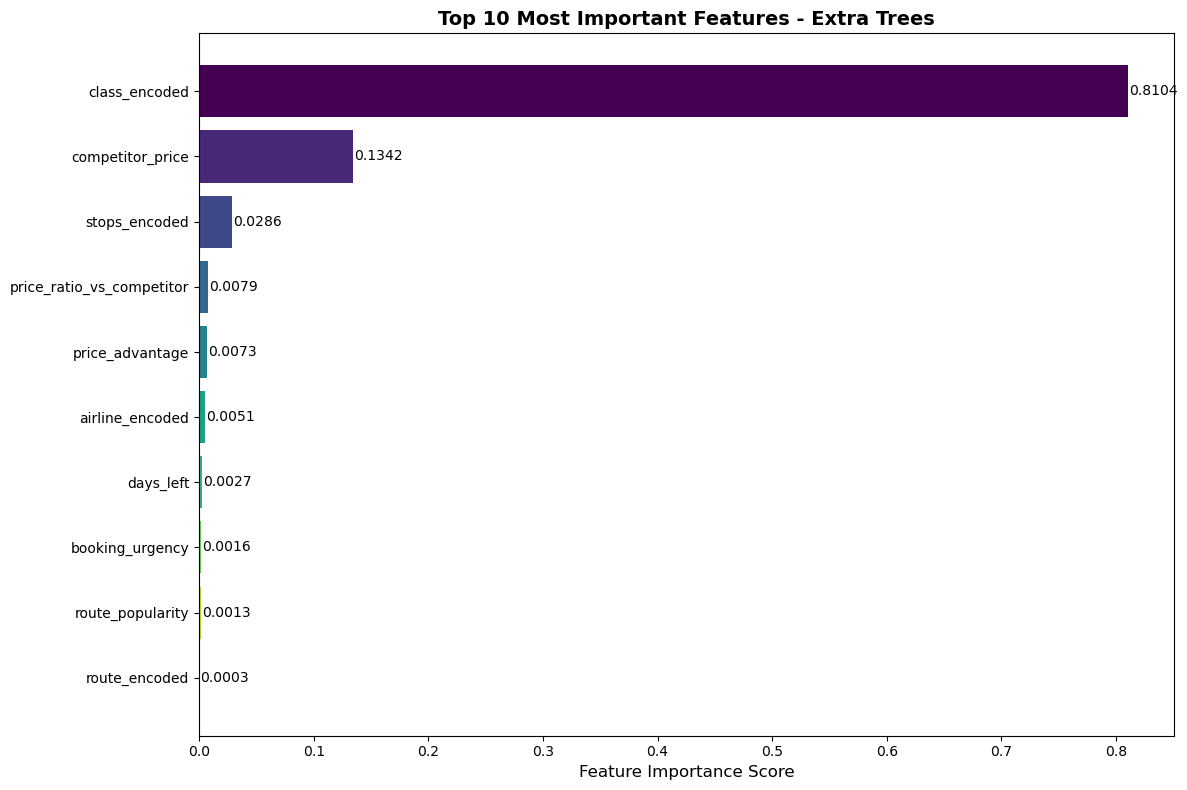


 Top 5 Most Important Features:
                  feature  importance
            class_encoded    0.810384
         competitor_price    0.134245
            stops_encoded    0.028607
price_ratio_vs_competitor    0.007896
          price_advantage    0.007297


In [30]:
# feature importance
try:
    if best_model is not None and hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(10)
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
        bars = plt.barh(top_features['feature'], top_features['importance'], color=colors)
        
        plt.xlabel('Feature Importance Score', fontsize=12)
        plt.title(f'Top 10 Most Important Features - {best_model_name}', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()

        for bar, value in zip(bars, top_features['importance']):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{value:.4f}', ha='left', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        print("\n Top 5 Most Important Features:")
        print(feature_importance.head().to_string(index=False))
        
    else:
        print(" Feature importance not available for this model type")

except Exception as e:
    print(f" Error in feature importance analysis: {e}")



In [31]:
# Business Impact Analysis

try:
    current_prices = y_test.values
    optimal_prices = y_pred_final

    min_price_multiplier = 0.7
    max_price_multiplier = 1.5
    
    constrained_optimal_prices = np.maximum(
        current_prices * min_price_multiplier,
        np.minimum(optimal_prices, current_prices * max_price_multiplier)
    )

    current_revenue = np.sum(current_prices)
    optimized_revenue = np.sum(constrained_optimal_prices)
    revenue_uplift = ((optimized_revenue - current_revenue) / current_revenue) * 100
    
    print(f"Current total revenue (test set): ₹{current_revenue:,.2f}")
    print(f"Optimized total revenue: ₹{optimized_revenue:,.2f}")
    print(f"Potential revenue uplift: {revenue_uplift:.2f}%")
    
    price_increases = constrained_optimal_prices > current_prices
    price_decreases = constrained_optimal_prices < current_prices
    no_changes = constrained_optimal_prices == current_prices
    
    print(f"\nPrice adjustments needed:")
    print(f"• Increase prices: {np.sum(price_increases)} flights ({np.mean(price_increases)*100:.1f}%)")
    print(f"• Decrease prices: {np.sum(price_decreases)} flights ({np.mean(price_decreases)*100:.1f}%)")
    print(f"• No change needed: {np.sum(no_changes)} flights ({np.mean(no_changes)*100:.1f}%)")

except Exception as e:
    print(f" Error in business impact analysis: {e}")

Current total revenue (test set): ₹1,254,288,489.00
Optimized total revenue: ₹1,254,197,403.48
Potential revenue uplift: -0.01%

Price adjustments needed:
• Increase prices: 29325 flights (48.8%)
• Decrease prices: 27270 flights (45.4%)
• No change needed: 3436 flights (5.7%)


In [32]:
# Save the trained model

import joblib
import os
from datetime import datetime

try:

    models_dir = '../models'
    os.makedirs(models_dir, exist_ok=True)

    model_artifacts = {
        'model': best_model,
        'model_type': best_model_name,
        'feature_columns': feature_columns,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'categorical_columns': categorical_columns,
        'performance_metrics': {
            'rmse': final_rmse,
            'mae': final_mae,
            'r2': final_r2,
            'mape': final_mape
        },
        'business_metrics': {
            'revenue_uplift': revenue_uplift,
            'avg_price_change': np.mean((constrained_optimal_prices - current_prices) / current_prices) * 100
        },
        'metadata': {
            'created_at': datetime.now().isoformat(),
            'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
    }
    
    joblib.dump(model_artifacts, '../models/pricing_model.pkl')
    print(" Model saved as '../models/pricing_model.pkl'")
    
except Exception as e:
    print(f" ERROR saving model: {e}")

 Model saved as '../models/pricing_model.pkl'


In [ ]:

print(" DYNAMIC PRICING ML PIPELINE COMPLETED SUCCESSFULLY!")

print(" Model Performance Summary:")
print(f"   Best Model: {best_model_name}")
print(f"   RMSE: ₹{final_rmse:.2f}")
print(f"   MAPE: {final_mape:.2f}%")
print(f"   R² Score: {final_r2:.4f}")
print(f"   Success Criteria Met: {rmse_met and mape_met}")
print(f"   Potential Revenue Uplift: {revenue_uplift:.2f}%")
print("\n Next Steps:")
print(" 1. Deploy model using Streamlit, FastAPI, and Flask")
print(" 2. Set up monitoring and maintenance system")
print(" 3. Integrate with airline booking systems")
 


🎉 DYNAMIC PRICING ML PIPELINE COMPLETED SUCCESSFULLY!
📊 Model Performance Summary:
   Best Model: Extra Trees
   RMSE: ₹90.46
   MAPE: 0.09%
   R² Score: 1.0000
   Success Criteria Met: True
   Potential Revenue Uplift: -0.01%

🚀 Next Steps:
   1. Deploy model using Streamlit, FastAPI, and Flask
   2. Set up monitoring and maintenance system
   3. Integrate with airline booking systems
